# Introduction

This notebook is meant to supplement the publication "Enhanancer RNA expression predicts TF activity." In brief, our group analyzed 494 and 273 human/mouse nascent transcript datasets and integrated 641 TF binding motifs. Becuase of the volume of data, we were unable to explore every possible comparison, cell type or treatment. With this in mind, the notebook will allow the user to explore experimental meta data, bidirectional transript predictions and integrated motif analysis.  





In [1]:
'''
    These are the required libraries/modules
    obviously if you can't run this cell then the rest of the notebook will fail
'''
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.stats import multitest
from MDAP.experiment import dataset
from MDAP.md_stats import mds_frame



sns.set_style("white")
%matplotlib inline






In [2]:
'''
    This .csv file contains all the meta data associated with each
    dataset. These easiest way to traverse this data is to use
    the pandas dataframe
    
    Below are a couple of examples demsontrating use of a pandas dataframe
    if you are new to pandas, you might find these useful:
    
    http://pandas.pydata.org
'''

conditions_table="./conditions_table.csv"
ct=pd.read_csv(conditions_table)

'''
    Retrieve all the "human" datasets
'''
human=ct[ct.organism=="human"].SRAnumber

'''
    Retrieve all the "human" datasets that are also are myeloid samples
'''
human_blood=ct[(ct.organism=="human") & (ct.tissue=="Myeloid") ].SRAnumber





In [3]:
'''
    The directory of motif displacement files. If you downloaded the tar ball from the "Enhanancer RNA expression 
    predicts TF activity."please chane accordingly. The default setting assumes you are running this notebook 
    within the motif_displacement_analysis
    cloned from git.
    
    Each file is uniquely name the SRA number and corresponds exactly to conditions_table.csv
'''

MDS_DIR = "./motif_displacement_files/"



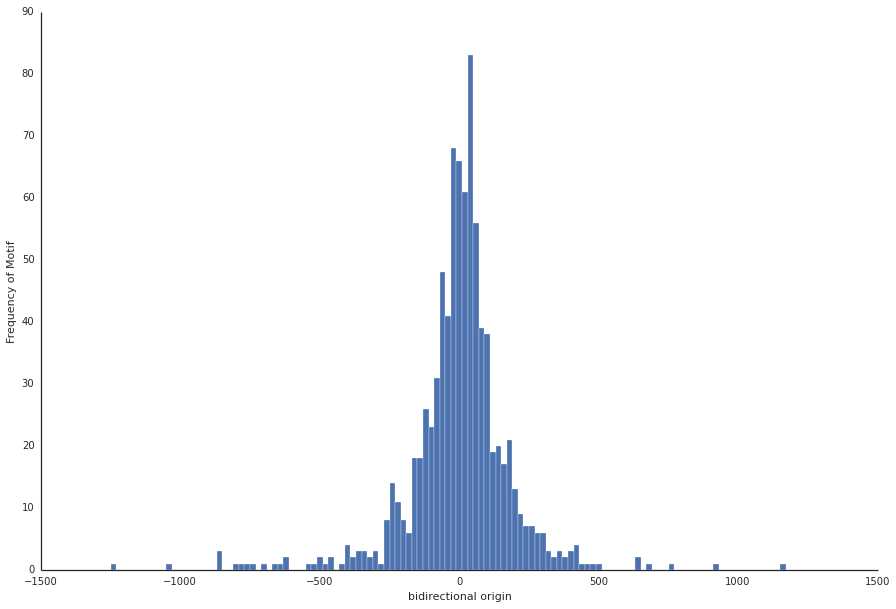

In [6]:
%matplotlib inline
sns.set_style("white")



'''
    Lets start by just looking at the motif displacement of specific motif of a specific dataset. For this,
    you will use to experiment.dataset class
'''
d = dataset(MDS_DIR+"SRR1015583" + "_MDS.csv")
'''
    So now that we have loaded this dataset we can call a few methods
'''
F  = plt.figure(figsize=(15,10))
ax = plt.gca()
'''
    Note that if you run this module outside the jupyer framework you will need to call plt.show()
'''
d.show_motif_displacement(Spec="HO_NRF1_HUMAN.H10MO.A",ax=ax,as_histogram=True)



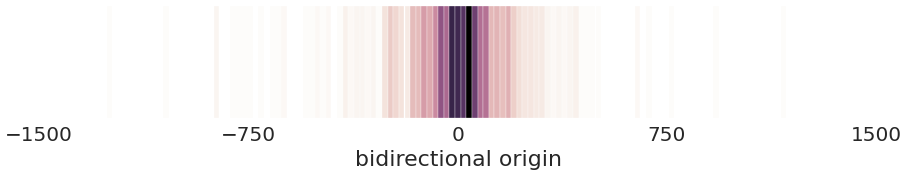

In [7]:
'''
    so that's kinda cool but it takes up a lot of page space!
'''
F  = plt.figure(figsize=(15,2))
ax = plt.gca()
d.show_motif_displacement(Spec="HO_NRF1_HUMAN.H10MO.A",ax=ax,as_histogram=False)




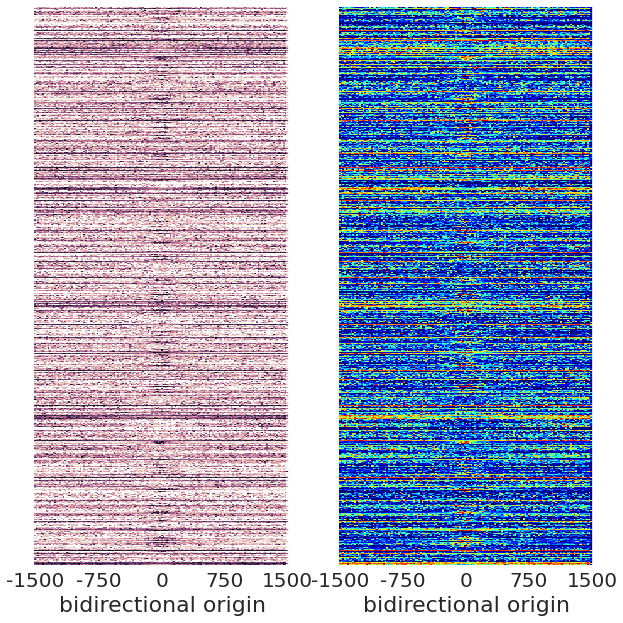

In [8]:
'''
    well okay, this is fine but are we going to do this for ALL 641 motifs?
'''


F  = plt.figure(figsize=(10,10))
ax1 = F.add_subplot(1,2,1)
ax2 = F.add_subplot(1,2,2)

motif_order = d.show_motif_displacement(All=True,ax=ax1)

'''
    obviously, placing show_histogram=True while All is turned on won't do anything!
'''

'''
    could we change the colormap?
'''
import matplotlib.cm as cm
cmap = cm.jet #maybe not this one! 
motifs = d.show_motif_displacement(All=True,ax=ax2,as_histogram=False,cmap=cmap)



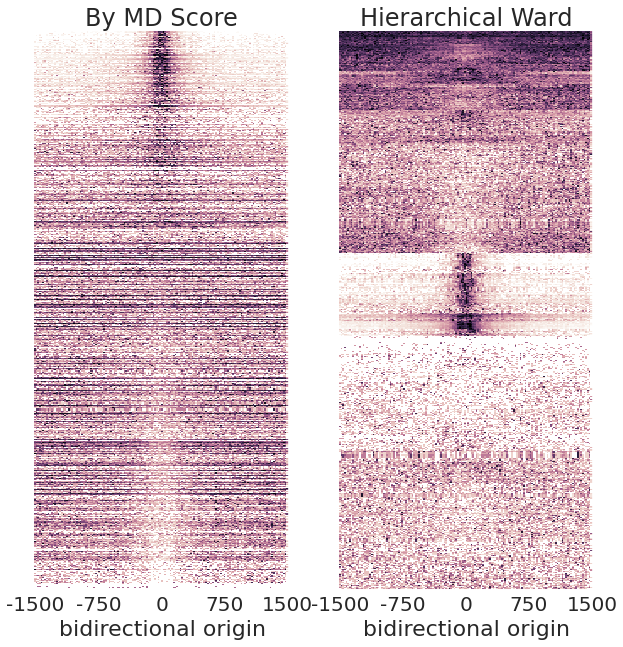

In [10]:
'''
what about ordering the rows?

1) either by hierarchical ward clustering of the normalized rows 
2) or 2, by MD score
'''
F  = plt.figure(figsize=(10,10))
ax1 = F.add_subplot(1,2,1)
ax2 = F.add_subplot(1,2,2)
ax1.set_title("By MD Score")
motif_order = d.show_motif_displacement(All=True,ax=ax1,sort_md=True)

ax2.set_title("Hierarchical Ward")
motif_order = d.show_motif_displacement(All=True,ax=ax2,clustering=True)




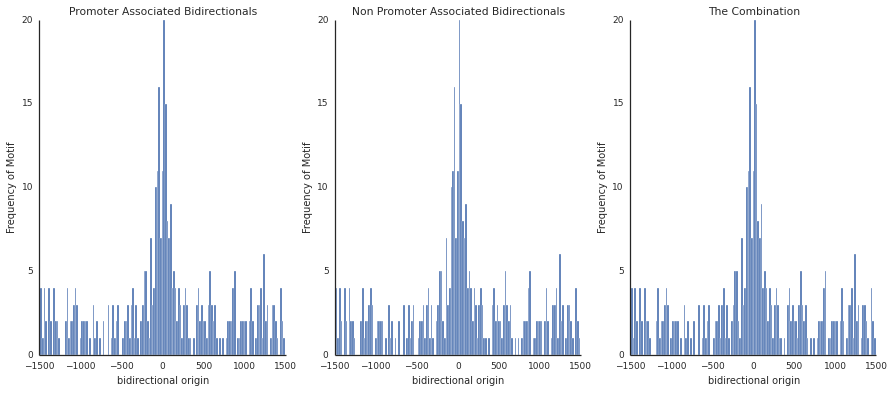

In [11]:
'''
    promoter vs non-promoter associated motif dispalcements?
    
    and of course you can tss and comb with All, Spec and as_histogram=False methods !
'''


sns.set(font_scale=0.9)
sns.set_style("white")

F  = plt.figure(figsize=(15,6))
ax1 = F.add_subplot(1,3,1)
ax2 = F.add_subplot(1,3,2)
ax3 = F.add_subplot(1,3,3)
ax1.set_title("Promoter Associated Bidirectionals")
ax2.set_title("Non Promoter Associated Bidirectionals")
ax3.set_title("The Combination")




motif_order = d.show_motif_displacement(Spec="HO_FOS_HUMAN.H10MO.A",ax=ax1,as_histogram=True,tss=True)

motif_order = d.show_motif_displacement(Spec="HO_FOS_HUMAN.H10MO.A",ax=ax2,as_histogram=True, tss=False,comb=False)

motif_order = d.show_motif_displacement(Spec="HO_FOS_HUMAN.H10MO.A",ax=ax3,as_histogram=True, tss=False,comb=True)








In [ ]:
'''
    can we quantify the peak from the noise in any meaningfuly way? Well the easiest attempt is the MD score 
    (described in our publication and used to assess if this peak has changed in any meaningful way) but we also
    developed a more advanced model: a uniform/laplace or uniform/gaussian mixture model which, when estimated 
    via the EM algorithm, can identify unimodal as well as bimodal peaks, see below for usage
    
    the core algorithm for this model fitting procedure is in
    
    normal_laplace.py (you can also toggle between normal or laplace components for modeling the peak)
'''
F  = plt.figure(figsize=(15,6))
ax1 = F.add_subplot(1,2,1)
ax2 = F.add_subplot(1,2,2)

M= "HO_NRF1_HUMAN.H10MO.A"
R = d.uni_bi(motif=M,norm=True) #gaussian
d.draw_density_function(R[0,0],R[0,1],R[0,2],ax=ax1)
d.show_motif_displacement(Spec=M,bins=200,ax=ax1,normed=1,as_histogram=True)

'''
    look at this motif displacement distribution!
'''

M2="HO_RUNX1_HUMAN.H10MO.A"
R = d.uni_bi(motif=M2,norm=False) #laplace
d.draw_density_function(R[0,0],R[0,1],R[0,2],ax=ax2)
d.show_motif_displacement(Spec=M2,bins=200,ax=ax2,normed=1,as_histogram=True)






# Differential Motif Displacement Analysis
The question of this section concerns whether the motif displacement distributions have significantly changed between these two experiments. Perhaps the simplest solultion would be non-parameteric KS-test. Another is look at statistics of the data for which we know, under assumptions of the null model, how these statistics will behave. Examples the sample mean or a local proportion of motifs surrounding eRNAs. In any case, the anlysis package here allows for integration of these statistics. 





In [ ]:
'''
    lets take a look at a couple of datasets to see what I mean;
    the first dataset SRR639050 is a IMR90 GRO-seq experiment treated with DMSO (the control)
    the second dataset SRR639051 is a IMR90 GRO-seq experiment treated with TNFalpha (the treatment)
    well known activator of the NFKB1/REL family of transcription factors. 
'''


exp1 = dataset(MDS_DIR+"SRR639050" + ".csv")
exp2 = dataset(MDS_DIR+"SRR639051" + ".csv")






In [ ]:
'''
    Lets look at the motif displacement distribution for NFKB1 surrounding eRNA origins before and after
'''
F  = plt.figure(figsize=(15,3))
ax1 = F.add_subplot(1,2,1)
ax2 = F.add_subplot(1,2,2)

ax1.set_title("Control (NFKB1)");ax2.set_title("Treatment (NFKB1)")
exp1.show_motif_displacement(Spec="HO_NFKB1_HUMAN.H10MO.B", as_histogram=False,ax=ax1,tss=0)
exp2.show_motif_displacement(Spec="HO_NFKB1_HUMAN.H10MO.B", as_histogram=False,ax=ax2,tss=0)




In [12]:
'''
    so obviosuly here is increase of motif events surrounding or proximal to eRNA localations. Can we quantify 
    this in any meaningful way? 
    
    Yes! And now we will use a different class which we call the mds_frame() 
    
    The mds_frame really only has two methods 
    
    1) load_MD_score_file() which takes any number .csv motif displacement files and a final string that is unique
        exerpiment identifier
    2) differential() which takes two strings (two of the unique experiment identifiers from one) to compare
        are returns of pandas dataframe
    
    Let me first just demonstrate use!
'''

md = mds_frame()
md.load_MD_score_file(MDS_DIR+"SRR639050" + ".csv", "control")
md.load_MD_score_file(MDS_DIR+"SRR639051" + ".csv", "TNFalpha")



TypeError: couldn't open:./motif_displacement_files/SRR639050.csv

In [ ]:
'''
    now that we have loaded these datasets we can call differential on them 
    
    this will likely take about 10 secnonds, with time proportion to the number of replicates you provide
'''

df = md.differential("control", "TNFalpha")



In [ ]:
'''
    now let's take a look at what is returned from this method
    
    we can first filter by some p-value cutoff
'''
dfs = df[df.pval_ks < pow(10,-5)]
dfu = df[df.pval_ks >= pow(10,-5)]


F   = plt.figure(figsize=(15,6))
ax1 = F.add_subplot(1,3,1)
ax2 = F.add_subplot(1,3,2)
ax3 = F.add_subplot(1,3,3)

'''
    now lets who how the local propotion of motifs chance between the two experiments
    as a function of the number of total motifs. In general, as the total number of motifs
    increases the relative variance (under a the normal model) should decrease as well
'''
ax1.scatter(dfs.counts, dfs.mds,edgecolor="white",color="red" )
ax1.scatter(dfu.counts, dfu.mds,edgecolor="white",color="blue" )


ax1.set_xscale("log");ax1.set_xlim(min(dfu.counts), max(dfu.counts) )
ax1.set_ylabel("Change in\nMotif Displacement Score")
ax1.set_xlabel("Total number of motif hits")

'''
    we can also just look at how the average distance to the eRNA origin changes
'''

ax2.scatter(dfs.counts, dfs.distance,edgecolor="white",color="red" )
ax2.scatter(dfu.counts, dfu.distance,edgecolor="white",color="blue" )
ax2.set_xscale("log");ax2.set_xlim(min(dfu.counts), max(dfu.counts) )
ax2.set_ylabel("Change in\nAverageDistance to eRNA origin")
ax2.set_ylim(-max(abs(dfs.distance) )-100,max(abs(dfs.distance) )+100 )
ax2.set_xlabel("Total number of motif hits")


ax3.hist(df.pval_ks,bins=100,edgecolor="white") 
ax3.set_xlabel("P-value")
ax3.set_ylabel("Frequency")

sns.despine(ax=ax1);sns.despine(ax=ax2);sns.despine(ax=ax3)
